https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import json
from glob import glob
from matplotlib import pyplot as plt
from tensorflow.keras.applications import vgg16
from random import shuffle
from scipy.special import softmax

In [ ]:
!wget https://github.com/a4tunado/lectures/archive/refs/heads/master.zip
!unzip master.zip

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
!cp /gdrive/'MyDrive'/'Компьютерное зрение'/the-nature-conservancy-fisheries-monitoring.zip .

In [5]:
!unzip the-nature-conservancy-fisheries-monitoring.zip

Archive:  the-nature-conservancy-fisheries-monitoring.zip
  inflating: sample_submission_stg1.csv.zip  
  inflating: sample_submission_stg2.csv.zip  
  inflating: test_stg1.zip           
  inflating: test_stg2.7z            
  inflating: train.zip               


In [6]:
!unzip sample_submission_stg1.csv.zip

Archive:  sample_submission_stg1.csv.zip
  inflating: sample_submission_stg1.csv  


In [ ]:
!unzip train.zip

In [8]:
train = glob('/content/train/*/*.jpg')
len(train)

3777

In [ ]:
!unzip test_stg1.zip

In [10]:
test= glob('/content/test_stg1/*')
len(test)

1000

In [11]:
TRAIN_PREFIX = '/content/train/'

def load_annotations():
    boxes = dict()
    for path in glob('lectures-master/007/data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

- Визуализируем разметку

In [12]:
boxes = load_annotations()

In [13]:
boxes['dol'][0]

{'annotations': [{'class': 'rect',
   'height': 73.3200000000001,
   'width': 238.29000000000042,
   'x': 501.2550000000009,
   'y': 459.6600000000009}],
 'class': 'image',
 'filename': '/content/train/DOL/img_07898.jpg'}

In [14]:
classes = pd.DataFrame([(k, len(v)) for k, v in boxes.items()], columns=['class', 'count']).sort_values(by='count', ascending=False)
classes

,class,count
0,alb,1719
1,yft,734
3,bet,200
5,shark,176
4,dol,117
2,lag,67


In [15]:
fish_classes = classes['class'].values
fish_classes

array(['alb', 'yft', 'bet', 'shark', 'dol', 'lag'], dtype=object)

{'annotations': [{'class': 'rect', 'height': 73.3200000000001, 'width': 238.29000000000042, 'x': 501.2550000000009, 'y': 459.6600000000009}], 'class': 'image', 'filename': '/content/train/DOL/img_07898.jpg'}


Text(0.5, 1.0, '/content/train/DOL/img_07898.jpg 720x1280')

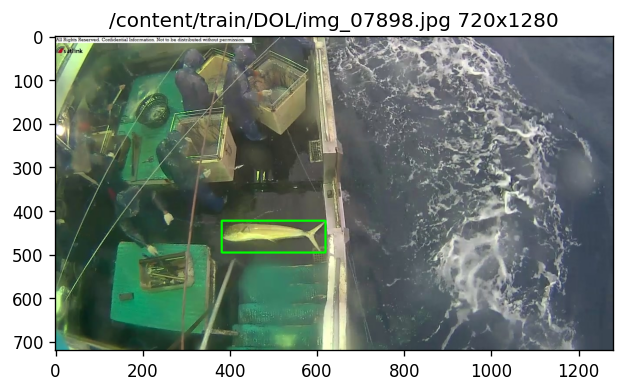

In [16]:
annotation = boxes['dol'][0]
print(annotation)
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title(f'{annotation["filename"]} {img.shape[0]}x{img.shape[1]}')

- Распределение размеров разметки

(array([ 229.,  980., 1287.,  876.,  384.,  169.,  102.,   22.,   20.,
          13.]),
 array([ 20.18638155,  65.96774339, 111.74910524, 157.53046708,
        203.31182893, 249.09319077, 294.87455262, 340.65591446,
        386.43727631, 432.21863815, 478.        ]),
 <BarContainer object of 10 artists>)

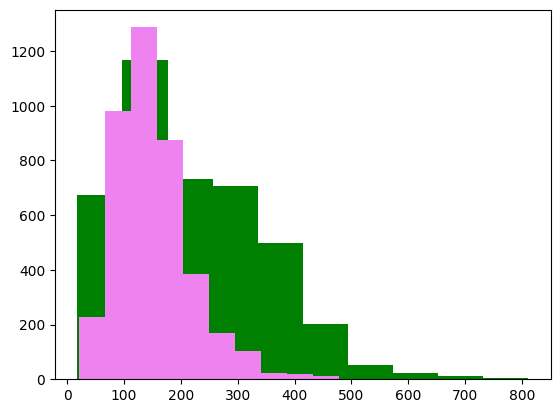

In [17]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths, color='green')
plt.hist(heights, color='violet')

- Экстрактор признаков

In [18]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

58889256/58889256 [==============================] - 2s 0us/step
(None, 23, 37, 512)


- Сетка якорей

In [19]:
FEATURE_SHAPE = (feature_tensor.shape[1], feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2 : IMG_HEIGHT : GRID_STEP_H, GRID_STEP_W/2 : IMG_WIDTH : GRID_STEP_W]

In [20]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y, anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0], FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]

    for rect in annotation['annotations']:
        scores = []
        label = fish_classes == rect['class']

        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [*label, 1., dx, dy, dw, dh]

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
          label = np.empty(6)
          label[0], label[1], label[2], label[3], label[4], label[5], conf, dx, dy, dw, dh = prediction[row, col]
          conf = _sigmoid(conf)
          label = softmax(label)

          if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': np.argmax(_sigmoid(label)),
                                   'labels': label })
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

- Валидация энкодинга/декодинга якорей

Text(0.5, 1.0, '/content/train/DOL/img_07898.jpg 720x1280')

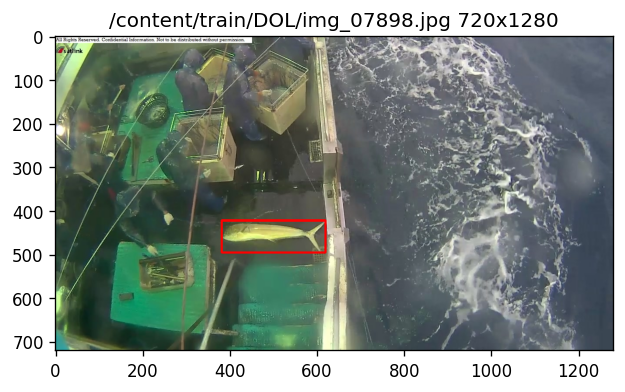

In [21]:
annotation = boxes['dol'][0]

encoded = encode_anchors(annotation, img_shape=(IMG_HEIGHT, IMG_WIDTH), iou_thr=0.1)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title(f"{annotation['filename']} {img.shape[0]}x{img.shape[1]}")

- Функция потерь

In [22]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 6], y_pred[..., 6], from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., -4:] - y_pred[..., -4:])
    square_loss = 0.5 * K.square(y_true[..., -4:] - y_pred[..., -4:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_tr, y_pr, alpha=0.25, gamma=2.0):
    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)

    probs = tf.nn.softmax(y_pred)
    alpha = tf.where(tf.equal(y_true, 1.0), alpha, (1.0 - alpha))
    pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
    loss = alpha * tf.pow(1.0 - pt, gamma) * cross_entropy

    return tf.reduce_sum(loss, axis=-1)

def class_loss(y_tr, y_pr):
    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]
    cross_entropy = K.categorical_crossentropy(y_true[..., :6], y_pred[..., :6], from_logits=True)

    return cross_entropy

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))

    cls_loss = classification_loss(y_true, y_pred)
    conf_loss = confidence_loss(y_true, y_pred)
    loc_loss = smooth_l1(y_true, y_pred)
    pos_conf_loss = K.sum(conf_loss * y_true[..., 6], axis=-1)
    pos_class_loss = K.sum(cls_loss * y_true[..., 6], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 6], axis=-1)

    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 6], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 6]), k=K.cast(num_neg, 'int32'))
    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    cls_loss = pos_class_loss / (num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss + cls_loss

- Загрузка данных

In [23]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

- Добавляем выход детектора

In [24]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)
output = tf.keras.layers.Conv2D(11, kernel_size=(1, 1),
                                activation='linear', kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0     

In [25]:
adam = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4, decay=1e-6)
model.compile(optimizer=adam, loss=total_loss, metrics=[confidence_loss])

In [26]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint('fishdetector.hdf5',
                                                monitor='loss',
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=False,
                                                mode='auto',
                                                save_freq=10)

model.fit(gen, steps_per_epoch=steps_per_epoch, epochs=10, callbacks=[checkpoint])

Epoch 1/10
  9/602 [..............................] - ETA: 5:35 - loss: 4.8875 - confidence_loss: 0.8413
Epoch 1: loss improved from inf to 4.65581, saving model to fishdetector.hdf5
 19/602 [..............................] - ETA: 5:25 - loss: 3.7515 - confidence_loss: 0.7988
Epoch 1: loss improved from 4.65581 to 3.66734, saving model to fishdetector.hdf5
 29/602 [>.............................] - ETA: 5:19 - loss: 3.1130 - confidence_loss: 0.7609
Epoch 1: loss improved from 3.66734 to 3.05989, saving model to fishdetector.hdf5
 39/602 [>.............................] - ETA: 5:18 - loss: 2.6921 - confidence_loss: 0.7281
Epoch 1: loss improved from 3.05989 to 2.66052, saving model to fishdetector.hdf5
 49/602 [=>............................] - ETA: 5:12 - loss: 2.3987 - confidence_loss: 0.7015
Epoch 1: loss improved from 2.66052 to 2.37208, saving model to fishdetector.hdf5
 59/602 [=>............................] - ETA: 5:08 - loss: 2.1791 - confidence_loss: 0.6764
Epoch 1: loss impro

- Результат работы детектора



In [27]:
# model.load_weights('/content/fishdetector/*.hdf5')

1/1 [==============================] - 4s 4s/step


Text(0.5, 1.0, 'Предсказание модели 750x1200')

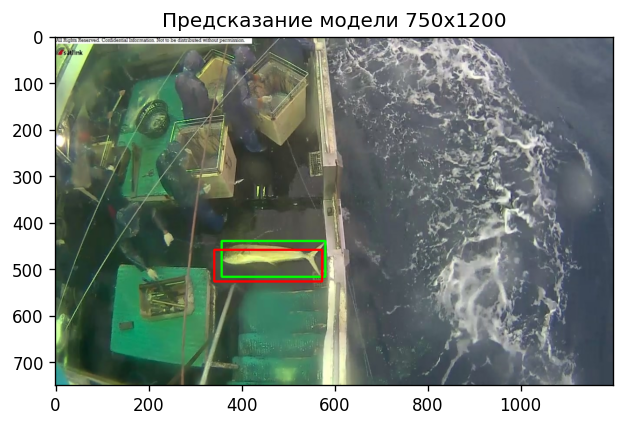

In [28]:
annotation = boxes['dol'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded, max_output_size=2, iou_threshold=0.5)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape))

- Визуализируем предсказание на тесте

1/1 [==============================] - 0s 29ms/step


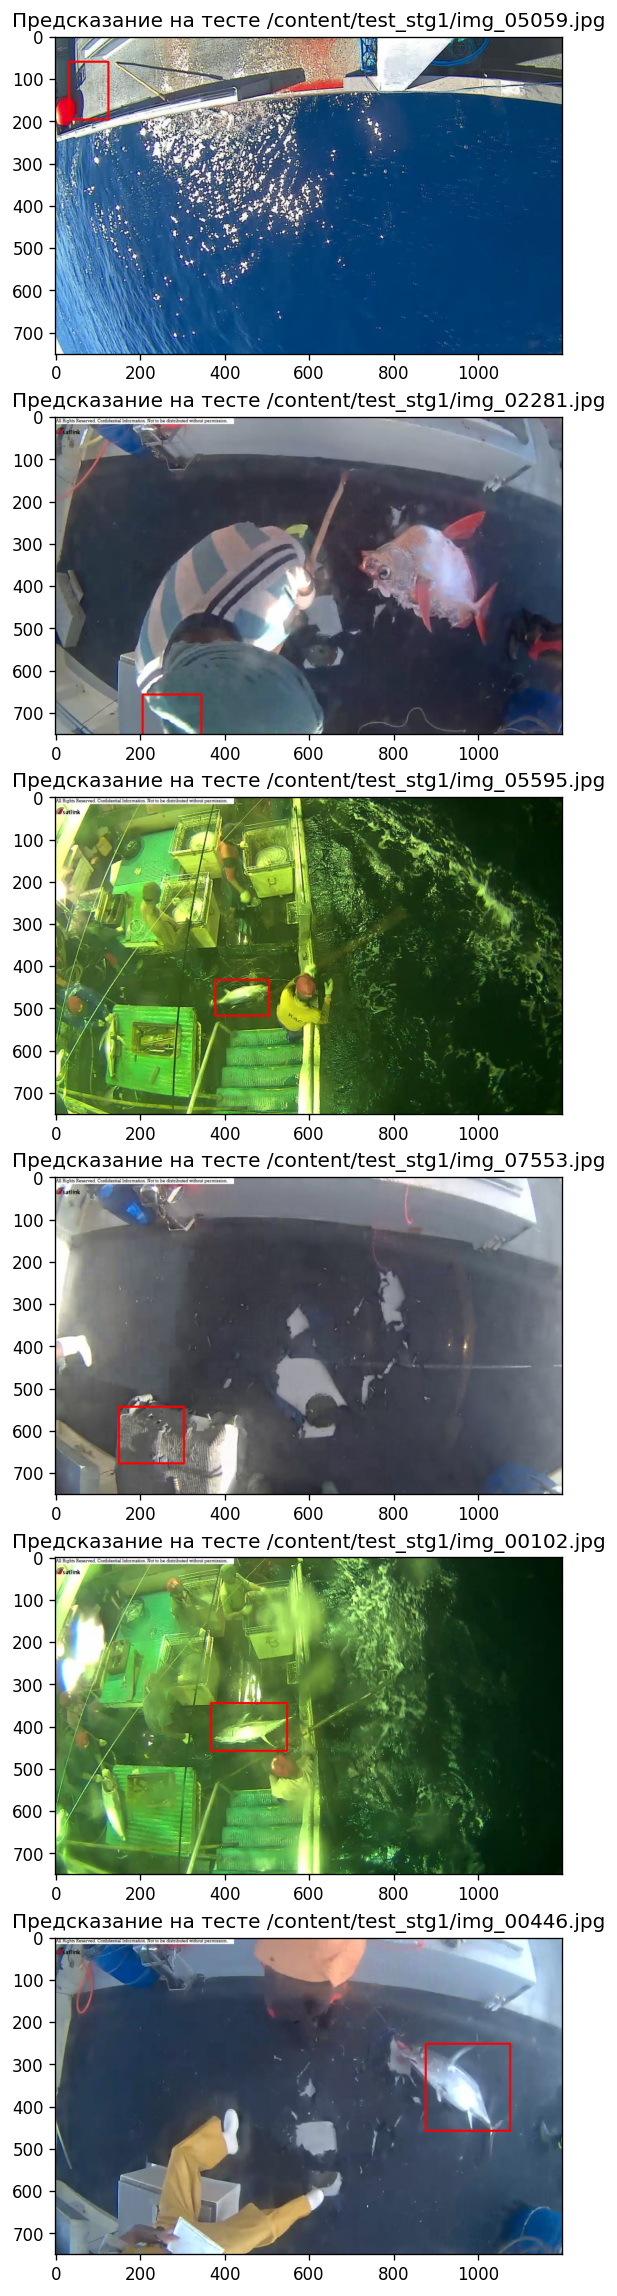

In [29]:
test_images = glob('/content/test_stg1/*')[100:106]

plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded, max_output_size=1, iou_threshold=0.5)

    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title(f'Предсказание на тесте {filename}')

In [ ]:
!pip install py7zr

In [31]:
!py7zr x '/content/test_stg2.7z'

In [34]:
def make_predictions():
    table = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])

    for i, file in enumerate(glob('/content/test_stg1/*.jpg')):
        bn = os.path.basename(file)
        _, sample_img = load_img(file)

        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.01)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)

        decoded = decoded[0]['labels']
        table.loc[i, 'image'] = bn
        table.loc[i, 'ALB'] = decoded[0]
        table.loc[i, 'BET'] = decoded[2]
        table.loc[i, 'DOL'] = decoded[4]
        table.loc[i, 'LAG'] = decoded[5]
        table.loc[i, 'SHARK'] = decoded[3]
        table.loc[i, 'YFT'] = decoded[1]
        table.loc[i, 'NoF'] = 0.123081
        table.loc[i, 'OTHER'] = 0.079142

    i += 1

    for j, files in enumerate(glob('/content/test_stg2/*.jpg')):
        bn = os.path.basename(files)
        bn = 'test_stg2/' + bn
        _, sample_img = load_img(files)

        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.01)
        decoded = non_max_suppression(decoded, max_output_size=1, iou_threshold=0.5)

        decoded = decoded[0]['labels']
        table.loc[i + j, 'image'] = bn
        table.loc[i + j, 'ALB'] = decoded[0]
        table.loc[i + j, 'BET'] = decoded[2]
        table.loc[i + j, 'DOL'] = decoded[4]
        table.loc[i + j, 'LAG'] = decoded[5]
        table.loc[i + j, 'SHARK'] = decoded[3]
        table.loc[i + j, 'YFT'] = decoded[1]
        table.loc[i + j, 'NoF'] = 0.123081
        table.loc[i + j, 'OTHER'] = 0.079142

    return table

In [ ]:
prediction_table = make_predictions()
prediction_table.to_csv('submit.csv', index=False)

In [ ]:
# prediction_table

In [37]:
x = pd.read_csv('submit.csv')
x

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_02666.jpg,0.164904,0.164731,0.163487,0.167384,0.123081,0.079142,0.167341,0.172153
1,img_00075.jpg,0.166995,0.167162,0.168175,0.166249,0.123081,0.079142,0.166440,0.164978
2,img_04757.jpg,0.167777,0.168111,0.169722,0.166039,0.123081,0.079142,0.165639,0.162713
3,img_05064.jpg,0.161602,0.161226,0.163570,0.167971,0.123081,0.079142,0.168024,0.177607
4,img_07143.jpg,0.170448,0.169652,0.168497,0.165775,0.123081,0.079142,0.165895,0.159732
...,...,...,...,...,...,...,...,...,...
13148,test_stg2/image_03085.jpg,0.167706,0.168164,0.169680,0.165860,0.123081,0.079142,0.165665,0.162924
13149,test_stg2/image_02337.jpg,0.167386,0.167090,0.165105,0.167074,0.123081,0.079142,0.166967,0.166378
13150,test_stg2/image_02588.jpg,0.166768,0.166616,0.167524,0.166630,0.123081,0.079142,0.166649,0.165814
13151,test_stg2/image_01948.jpg,0.168374,0.168281,0.167541,0.166401,0.123081,0.079142,0.166455,0.162948
